<a id='k-means'></a>
I want to start this little machine learning blog with a simple but effective algorithm to identify [clusters](https://en.wikipedia.org/wiki/Cluster_analysis) in data. For those that are not familiar with the concept that means finding groups, it could be used for finding  relations in all the observations that belongs to a cluster or just to find the number of different clusters in some data, for example in a social network, or whatever.

As this is the first post I will explain some things about notations, that are also on the introduction:

- All vectorial variables are written in bold ex: $ \mathbf{x} , \mathbf{y} $.

- All the vectors are always column vectors (unless otherwise stated) so a $ x $ vector of size $ N $ would be written as: 

  $\mathbf{x} = \begin{bmatrix}  x_1 \\ x_2 \\ \vdots\\ x_n \end{bmatrix} $  or $ \mathbf{x} = \begin{bmatrix}  x_1, \ x_2,\ \dots, \ x_n \end{bmatrix}^T $

- Matrices are written both in bold and in uppercase, ex: $ \mathbf{X},  \mathbf{Y} $

  so if the size of $ \mathbf{X} $ is $N\times D$: 

   $  \mathbf{X} = \begin{bmatrix}    x_{11} & \dots  & x_{1d} \\    x_{21} & \dots  & x_{2d} \\    \vdots & \ddots & \vdots \\    x_{n1} & \dots  & x_{nd}\end{bmatrix} $


K-means is an algorithm to partition $ N $ observations of a random D-dimensional variable $ \mathbf{X}$ (which we will refer as the dataset) into $ \mathit{K} $ clusters, the value of $ \mathit{K} $ is given to us. We can think of a cluster as a group of points (from the dataset) whose distance between each other are small compared to distances to points outside of the cluster.


## The Dataset

Lets study first the dataset we are going to work with. I chose one called old faithful, and if you ever read a book about machine learning you will study it deeply.

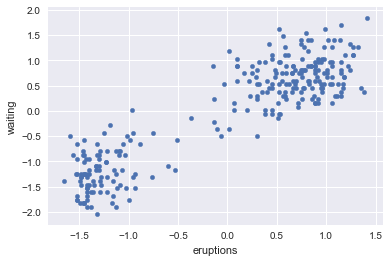

In [10]:
%matplotlib inline
#loading the dataset
import numpy as np
import pandas as pd
import seaborn as sns # Nice plots
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from scipy.spatial.distance import cdist

df = pd.read_csv('old_faithful.csv')
df.round(2) # Round all data to two decimal places
df.drop(df.columns[0], axis=1, inplace=True) # Drop 1st column, we now have: 'eruptions' and 'waiting'
df = (df - df.mean()) / df.std() # Standarize the data (make each variable zero mean and unit standard deviation)
df.plot(x='eruptions', y='waiting', kind='scatter')
plt.show()

As you can see we are working in two dimensions (waiting time and eruptions), the code above rounds all the data to two decimals places, then "deletes" the first column (we don't need it, is just an index) and last it [standardizes](https://stats.idre.ucla.edu/stata/faq/how-do-i-standardize-variables-in-stata/) the data.
and we can already clearly see two clusters. If you don't see the clusters that I'm talking about I can help you with my ultra MS paint&trade; skills.

![Two Clusters, see?](images\dont_you_see_the_clusters.png "Two Clusters, see?")

## Formalizing the dataset

Lets start by naming some of the variables that we are going to use.

We are working in two dimensions right? and we [stated](#k-means) that we are working with a dataset $ \mathbf{X} $ of size $ N \times D $. Here we have our first variables:

$ \mathbf{X} $ is the dataset matrix, one row for each observation, and each observation has two values (waiting and eruptions) so we got that the size of the matrix is:

$ N = 272 $ (trust me on this one) $\times$ $ D = 2 $

Now we need to choose in how many cluster we want to divide the data, we already saw that there are probably two clusters, so lets assume that, set $ K = 2 $.

we can now add that to the code

In [11]:
X = df.as_matrix()
N = X.shape[0]
K = 2
D = X.shape[1] # number of dimensions of the problem

$\newcommand{\bs}[1]{\boldsymbol{#1}}$
$\newcommand{\Epsilon}[0]{\mathcal{E}}$
We are still missing some things before we can start, if we are going to create clusters we need to define the centers of the clusters, for example we can store one of the centers in a variable $ \bs{\mu} $ that would need to be of size D. If we have K clusters then our variable $ \bs{\mu} $ (it's uppercase even if it doesn't look like it) would be of size $ K\times D $.

we also need something to describe to which cluster is each point assigned we can do that with another matrix $R$ of size $N\times K$, the matrix means something like this: We have a row for each of the points ($N$) and each row has $1$ in the position of the cluster that the point is assigned to and $0$ on the rest of the positions.

Here is an example to understand it better:

$$ \underset{N\times K}{\mathbf{R}} = \begin{bmatrix}
    1 & 0\\
    0 & 1\\
    1 & 0 \\
    \vdots & \vdots
    \end{bmatrix} $$
    
It says that the first datapoint is assigned to the first cluster, the second point to the second one and the third one to the first cluster. (note that **each point can only be assigned to one and only one of the clusters**).



## Math time

Now we need and algorithm that give us the best choices for both the assignments and the centers of the clusters but
if we expect to implement an algorithm we are going to need math, don't worry this ones aren't complicated.

We can start with a function $J()$ that tell us how good or how bad our algorithm is doing, we call that *the objective funcion* or *the error function* and we can use something as simple as this:
$$ J = \sum_{n=1}^{N}\sum_{k=1}^{K} r_{nk}|| \bs{x_n} - \bs{\mu_k} ||^2 \tag{1}$$ 

This represents the [sum of the squares](https://en.wikipedia.org/wiki/Euclidean_distance#Squared_Euclidean_distance) of the distances of each point to the center of the assigned cluster. 

We can break the equation to understand it better (or you can skip the exaplanation if you feel confident).
we are going to loop through all the points and all the clusters that means that if $r_{nk} = 1 $ we are in a point $ x_n $ that belongs to the cluster $ k $ and we calculate the distance from $ \bs{x_n} $ to $ \bs{\mu_k} $ and we add that value to our total error (we are in a summation). If $r_{nk} = 0 $ the point doesn't belong to the cluster and we don't even need to calculate anything, we sum 0 to the error.

Okay so now we have some function that we can call with some parameters and give us a number that tell us if we are in the correct path to solve the problem, we obviously want a small error, so we want to minimize $J$.

take a look at $ (1) $ again, we see that it depends on $\bs{X}, \mu $ and $\bs{R}$, and of that list we can only change $ R $ and $ \mu $ so our goal now is to find the values of those variables that minimize $J$, we can do that in two phases, first minimizing $J$ with respect to $\bs{R}$ fixing the other parameters and then with respect to $\mu $ fixing the other parameters.

## Optimize $R$

because $(1)$ is a linear function of $r_{nk}$ we can optimize for each datapoint esparately by doing this:

$$ 
r_{nk} = 
\begin{cases} 
    1 & \text{if $k$ = arg  $min_j || \bs{x_n} - \bs{\mu_j} ||^2 $} \\
    0 & \text{otherwise} 
\end{cases}
$$

intuitively that means that we assign the $n^{th}$ data point to the closest cluster centre.

now to optimize the cluster centres $\bs{\mu_k} $ we can set the derivative of $(1)$ to zero with respect to $\bs{\mu_k} $ and we have
$$
2\sum_{n=1}^{N}r_{nk}(\bs{x_n} - \bs{\mu_k}) = 0
$$
$$
\bs{\mu_k} = \frac{\sum_{n=1}^{N} r_{nk}\bs{x_n}}{\sum_{n=1}^{N}r_{nk}} \tag{2}
$$

eq $(2)$ just says: 
$$ 
\bs{\mu_k} = \frac{\text{sum of the values of points assigned to cluster k}}{\text{number of points assigned to cluster k}}
$$

[sounds familiar?](https://en.wikipedia.org/wiki/Arithmetic_mean), well that is why is called K-means. Now we can start with the fun part and code all of this.

Note: the trick to an algortihm fast in machine learning is to vectorize all the operations instead of looping through the values. we could code the eq. $(1)$ as two for loops but we will be making our algorithm $O(N^2)$ if we code it the way is done below the time complexity is $O(N)$ but it is equivalent. we also converted the matrix $R$ in a vector called `labels` of size $N$ which each value can take any number from $ 0 $ to $ K - 1$

In [12]:
# Error function
def J(distances, labels):
    error = 0
    for n, distance in enumerate(distances):
        error += distance[labels[n]] # we could have made it even more vectorial, but it's not worth it
    return error


We can start initializing the cluster centers at random (or better, choose some acceptable centers).
We then calculate the distances matrix `squared_distances` (corresponding to $|| \bs{x_n} - \bs{\mu_k} ||^2  $ and to which cluster are closer, called `labels`.

I also printed the error (this is optative but helps so we know if we are doing it right, because it should be decreasing in each iteration).

This is the final code then:

Current error: 2338.8109157948793
Current error: 252.37915008939842
Current error: 79.83246726670576
Current error: 79.37287654881261
Current error: 79.31314233585128
Current error: 79.28340081368775
Current error: 79.28340081368775


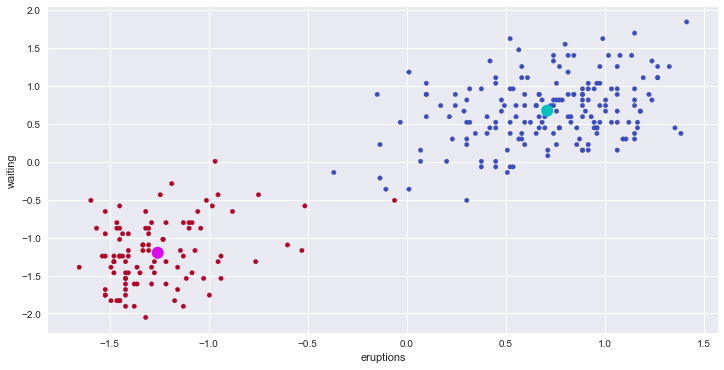

In [13]:
plt.rcParams["figure.figsize"] = [12, 6] #Bigger images

MU = np.array([[-2.0, 2.0], [1.5, -2.5]])
max_iterations = 7

for _ in range(max_iterations):
    # Calculate distance from each datapoint to each cluster center
    squared_distances = cdist(X, MU, 'sqeuclidean') # NxK matrix
    labels = np.argmin(squared_distances, axis=1) # Nx1 and each value tell us which index is associated which each datapoint

    # calculate the means of all datapoints assigned to each cluster (Kx1)
    for k in range(K):
        # points_of_cluster k -> X[labels == k]
        # new centers
        MU[k] = np.mean(X[labels == k], axis=0) #out=MU[k]    
    # Error should be decreasing
    print("Current error: {0}".format(J(squared_distances, labels)))
    # end of iteration, now we have labels of which cluster the datapoint is associated and the new cluster locations (MU)
#plt.figure()
df = df.assign(labels=labels)
df.plot.scatter(x='eruptions', y='waiting', c='labels', colormap=cmx.coolwarm, colorbar=False)

plt.scatter(MU[:,0], MU[:,1], marker='o', linewidths=5, color=['c', '#DA0AF0'])
plt.show()

We see the two clusters (in red and blue), corresponding to plotting the matrix $x$ and choosing the color according to the value of `labels[N]` (if is equal to 0 or 1).

The cluster centers are also plotted (in magenta and cyan) and effectively we see that it correspond to the mean value of all the points of each cluster.

Last, we can check that in each iteration the error was decreasing, I can plot that too so we can also see that there is a point that it barely changes (we say that "the algorithm has converged")

![Plotting Error](images\error_minimizing.png "Error reduction")


I also created a gif ilustrating each iteration of the algorithm. I plotted two figures for each iteration, one showing the updates of the labels, each point get assigned to a center deopending on in which line of the line is at (that's the perpendicular bisector between the centers) and another update showing the centers.

![Iterations](images\iterations.gif "Iterations")

And that was pretty much everything, you can [download the source]({attach}/code/k_means.zip) and soon I will upload another blog entry with an interesting application of K-means to image compression.



###### References

Bishop, Christopher M. Pattern recognition and machine learning. springer, 2006.

https://en.wikipedia.org/wiki/Cluster_analysis

https://en.wikipedia.org/wiki/K-means_clustering

https://stats.idre.ucla.edu/stata/faq/how-do-i-standardize-variables-in-stata/

https://en.wikipedia.org/wiki/Arithmetic_mean